capturing image
barcode string: 11N
Start direction: N
Starting room: 11
Sending starting room to Server
Server response: path to product is ES
Cropping image...


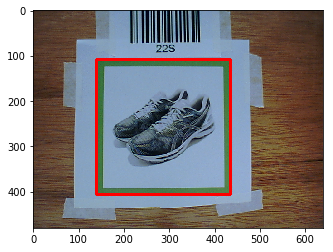

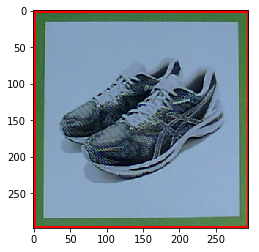

Tweeting @Tufts ES2
['table', 'sitting', 'small', 'white', 'board', 'different', 'pair', 'monitor', 'holding', 'fruit', 'food', 'computer', 'cat', 'laying', 'desk', 'cake', 'group', 'blue']


In [2]:
#INSERT CAMERA
import time, gopigo3, easysensors, cv2, socket, json, requests
import easygopigo3 as easy
import numpy as np
import matplotlib.pyplot as plt
import pyzbar.pyzbar as pyzbar
import random as r
import numpy as np
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
from requests_oauthlib import OAuth1

IP_address = '10.245.159.131' 
#Choose a port number above 1024. Match server port
PORT_num = 2460 
BUFFER = 1024

def sendData(msg):
    # connect to server, send message, get back response
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM) # set up socket
    s.connect((IP_address, PORT_num))
    s.sendall(msg) # send message
    data = s.recv(BUFFER) # get back response
    s.close() # tells the server that the connection is done
    # print what was returned by server
    return data

gpg = gopigo3.GoPiGo3()
egpg = easy.EasyGoPiGo3()

gpg.reset_all()

# Motor SET UP
motorL = gpg.MOTOR_LEFT
motorR = gpg.MOTOR_RIGHT

#Line Follow SET UP
LINE_PORT = gpg.GROVE_1
LINE_PIN = gpg.GROVE_1_1
gpg.set_grove_type(LINE_PORT, gpg.GROVE_TYPE.CUSTOM)
gpg.set_grove_mode(LINE_PORT, gpg.GROVE_INPUT_DIGITAL)
LINE    = 0
NO_LINE = 1

l_eye = gpg.LED_LEFT_EYE
r_eye = gpg.LED_RIGHT_EYE

#Ultrasonic SET UP
US_PORT = gpg.GROVE_2
US_TYPE = gpg.GROVE_TYPE.US

gpg.set_grove_type(US_PORT, US_TYPE)

# WRITE YOUR LINE FOLLOWING CODE HERE

#distance = gpg.get_grove_value(US_PORT)

def stopinmid():
    distance = 255
    while distance >= 220:
        try:
            distance = gpg.get_grove_value(US_PORT)
        except gopigo3.SensorError:
            pass
        except gopigo3.ValueError:
            pass
        if gpg.get_grove_state(LINE_PIN) == LINE:
            gpg.set_motor_power(motorL, 50)
            gpg.set_motor_power(motorR, 75)
        if gpg.get_grove_state(LINE_PIN) == NO_LINE:
            gpg.set_motor_power(motorL, 75)
            gpg.set_motor_power(motorR, 50)  
    gpg.set_motor_power(motorL, 0)
    gpg.set_motor_power(motorR, 0)



#insert loop for tunrtolist
def directionturn(start):
 #will reassignment carry over to while loop and/or turn function?
    if start == 'N' and turnto == 'E':
        start = turnto
        return 'right'
    if start == 'N' and turnto == 'W':
        start = turnto
        return 'left'
    if start == 'N' and turnto == 'S':
        start = turnto
        return 'around'
    if start == 'N' and turnto == 'N':
        start = turnto
        return 'straight'
    if start == 'E' and turnto == 'E':
        start = turnto
        return 'straight'
    if start == 'E' and turnto == 'W':
        start = turnto
        return 'around'
    if start == 'E' and turnto == 'S':
        start = turnto
        return 'right'
    if start == 'E' and turnto == 'N':
        start = turnto
        return 'left'
    if start == 'S' and turnto == 'E':
        start = turnto
        return 'left'
    if start == 'S' and turnto == 'W':
        start = turnto
        return 'right'
    if start == 'S' and turnto == 'S':
        start = turnto
        return 'straight'
    if start == 'S' and turnto == 'N':
        start = turnto
        return 'around'
    if start == 'W' and turnto == 'E':
        start = turnto
        return 'around'
    if start == 'W' and turnto == 'W':
        start = turnto
        return 'straight'
    if start == 'W' and turnto == 'S':
        start = turnto
        return 'left'
    if start == 'W' and turnto == 'N':
        start = turnto
        return 'right'
    
right = -45
left = 45
straight = 0
around = 150

def spinline(amount):
    # spin a certain amount
    motor_degrees = (amount*320)//180
    start = gpg.get_motor_encoder(gpg.MOTOR_RIGHT)
    if amount > 0:
        while True:
            gpg.set_motor_power(motorL, -50)
            gpg.set_motor_power(motorR, 50)
            end = gpg.get_motor_encoder(gpg.MOTOR_RIGHT)
            if end-start == motor_degrees:
                gpg.set_motor_power(motorL, 0)
                gpg.set_motor_power(motorR, 0)
                break
        while True:
            if gpg.get_grove_state(LINE_PIN) == NO_LINE:
                gpg.set_motor_power(motorL, 0)
                gpg.set_motor_power(motorR, 0)
                break
            if gpg.get_grove_state(LINE_PIN) == LINE:
                gpg.set_motor_power(motorL, -50)
                gpg.set_motor_power(motorR, 50)
                
    elif amount < 0:
        while True:
            gpg.set_motor_power(motorL, 50)
            gpg.set_motor_power(motorR, -50)
            end = gpg.get_motor_encoder(gpg.MOTOR_RIGHT)
            if end-start == motor_degrees:
                gpg.set_motor_power(motorL, 0)
                gpg.set_motor_power(motorR, 0)
                break
        while True:
            if gpg.get_grove_state(LINE_PIN) == NO_LINE:
                gpg.set_motor_power(motorL, 0)
                gpg.set_motor_power(motorR, 0)
                break
            if gpg.get_grove_state(LINE_PIN) == LINE:
                gpg.set_motor_power(motorL, 50)
                gpg.set_motor_power(motorR, -50)
    elif amount == 0:
        while True:
            gpg.set_motor_power(motorL, 0)
            gpg.set_motor_power(motorR, 0)
            break
def turn():
    if direction == 'right':
        spinline(right)
    elif direction == 'left':
        spinline(left)
    elif direction == 'straight':
        spinline(straight)
    elif direction == 'around':
        spinline(around)
        
def throughdoor():
    distance = 245
    while distance <= 280:#280:
        try:
            distance = gpg.get_grove_value(US_PORT)
        except gopigo3.SensorError:
            pass
        except gopigo3.ValueError:
            pass
        if gpg.get_grove_state(LINE_PIN) == LINE:
            gpg.set_motor_power(motorL, 50)
            gpg.set_motor_power(motorR, 75)
        if gpg.get_grove_state(LINE_PIN) == NO_LINE:
            gpg.set_motor_power(motorL, 75)
            gpg.set_motor_power(motorR, 50)
    gpg.set_motor_power(motorL, 0)
    gpg.set_motor_power(motorR, 0)
    
def convertToRGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def decode_barcode(img):
    # decode the barcode within img and return the barcode obj
    barcodeobj = pyzbar.decode(img) 
    return barcodeobj


def decode_barcode_data(barcode_obj):
    for obj in barcode_obj:
        type = obj.type
        mystring = obj.data
        mystring = mystring.decode("utf-8")
        return mystring
    
    
def decode_barcode_center(barcode_obj):
    hCenter = ''
    for obj in barcode_obj:
        #print (obj.rect)
        hCenter = int(obj.rect.left + (obj.rect.width/2))
        height = int(obj.rect.height)
        top = int(obj.rect.top)
    return hCenter


def capture_image():
    # open camera/capture image
    cam = cv2.VideoCapture(0)
    _,img = cam.read() # read image from camera
    cam.release() #release (close) camera
    return img

def scan_barcode(img):

    # decode barcode
    barcode_obj = decode_barcode(img)
    barcode_string = decode_barcode_data(barcode_obj)
    print('barcode string: ' + str(barcode_string))
    #print('Barcode string:', barcode_string)

    # find center of barcode
    barcode_center = decode_barcode_center(barcode_obj)
    #print('Barcode center:', barcode_center)


    #Exercise 11.02
    room_number = barcode_string[:2]
    cardinal_direction = barcode_string[2]
    #Exercise 11.02a (error cases 20 or so lines above)
    #print("Room:", room_number, "  Direction:", cardinal_direction)
    img = convertToRGB(img)
    data = str(room_number) + str(cardinal_direction)
    return data

def decode_barcode(img):
    # decode the barcode within img and return the barcode obj
    barcodeobj = pyzbar.decode(img) 
    return barcodeobj


def decode_barcode_data(barcode_obj):
    for obj in barcode_obj:
        type = obj.type
        mystring = obj.data
        mystring = mystring.decode("utf-8")
        return mystring
def crop(img):
    
    min_x = 700
    min_y = 700
    max_x = -1
    max_y = -1

    minx = True
    miny = True
    maxx = True
    maxy = True

    for i in range (480):
        for j in range (640):
            if img[i,j,1] > min_green and img[i,j,0] < max_blue and img[i,j,2] < max_red:
                if i < min_y:
                    min_y = i
                if i > max_y: 
                    max_y = i
                if j > max_x:
                    max_x = j
                if j < min_x:
                    min_x = j

    if min_x > 640: #checks to see if new boundaries have been made
        minx = False #if not, then it sets the edge of the picture
        max_x = 639 #as its boundaries, and sets boolean to False
    if min_y > 480:
        miny = False
        max_y = 479
    if max_x < 0: 
        maxx = False
        min_x = 1
    if max_y < 0:
        maxy = False
        min_y = 1
     
    cv2.rectangle(img, (min_x,min_y), (max_x,max_y), (255,0,0), 5)
    img2 = img[min_y:max_y, min_x:max_x] 
    
    
    if not minx and miny and maxx and maxy:
        plt.figure()
        plt.imshow(img)
        plt.show()
        return False
    else: 
        plt.figure()
        plt.imshow(img)
        plt.show()
        return img2

def check_green(img):
    count = 0
    for i in range (480):
        for j in range (640):
            if img[i,j,1] > min_green and img[i,j,0] < max_blue and img[i,j,2] < max_red:
                count +=1
    if count > 5:
        return True
    else: 
        return False
    
def getKey(filename):
    fin = open(filename)
    for line in fin:
        key = line.strip()
    return key

# get the Twitter Key/Secret from a local file
def getTwitterKeys(filename):
    fin = open(filename)
    consumer_key = fin.readline().strip() # read line 1
    consumer_secret = fin.readline().strip() # read line 2
    access_token = fin.readline().strip() # read line 3
    access_secret = fin.readline().strip() # read line 4
    fin.close()
    return consumer_key, consumer_secret, access_token, access_secret

stopinmid()
print('capturing image')
img = capture_image()
barcode_data = scan_barcode(img)
right = -45
left = 45
straight = 0
around = 170
filename = 'startroom.png'
cv2.imwrite(filename, img)

start_direction = barcode_data[2]
#start_direction = 'S'

print('Start direction: ' + str(start_direction))

starting_room = str(barcode_data[0:2])
#starting_room = '21'

apikeyfile = 'TwitterKey.txt'
consumer_key, consumer_secret, access_token, access_secret = getTwitterKeys(apikeyfile)
# set up authentication
twitter_auth = OAuth1(consumer_key, client_secret=consumer_secret,
                      resource_owner_key=access_token, resource_owner_secret=access_secret)

# image to upload
image_path = "startroom.png"

#### STEP ONE: UPLOAD MEDIA TO TWITTER (and get back a media id)
#### Use 'https://upload.twitter.com/1.1/media/upload.json'

# set up the twitter call: NOTE UPLOAD (not API)
media_base_url = 'https://upload.twitter.com/'
# media upload URL
media_post_url = '{}1.1/media/upload.json'.format(media_base_url)

image_data = open(image_path, "rb").read() #read byte data of image
files = {'media': image_data}

# post to twitter (to the media_post_url)
response = requests.post(media_post_url, files=files, auth=twitter_auth)

### DEBUGGING:
#print("Response:", response) # should be <200> meaning it worked
#print() # new line
#print("Text:", response.text) # reply back from Twitter about our post
#print() # new line
#print("JSON:", json.loads(response.text)) # should have the media_id
#print() # new line

# GET THE MEDIA ID:
media_id = json.loads(response.text)['media_id']

#print("Media ID:", media_id) # this number represents our image on Twitter server

#### STEP TWO: using media_id, now post a status (and link to that image)
#### THIS IS THE SAME AS YOU HAVE DONE BEFORE, just adding "media_ids" parameter

# set up the twitter call
base_url = 'https://api.twitter.com/'
# post_url (for updating status)
post_url = '{}1.1/statuses/update.json'.format(base_url)

# post parameters
message = '@TuftsES2Bot Team Emerald starting in room ' + str(starting_room) + '!'
post = {"status": message, "media_ids": media_id} # media_id from above!

response = requests.post(post_url, data=post, auth=twitter_auth)

#######

print('Starting room: ' + str(starting_room))
print('Sending starting room to Server')

path = sendData(starting_room.encode("utf-8")).decode("utf-8")
#path = 'P'

print('Server response: path to product is ' + str(path))
if path == 'P':
    print('Product already in room')
    turnto = 'S'
    direction = directionturn(start_direction)
    turn()
else:
    for i in range(1):
        for letter in path:
            stopinmid() #stops in middle of room
            turnto = letter
            direction = directionturn(start_direction)  #translates cardinal direction to left/right
            turn() #turns given direction
            throughdoor() 
            stopinmid()
            start_direction = letter#goes through door
        turnto = 'S'
        direction = directionturn(start_direction)
        turn()
        
min_green = 100
max_red = 75
max_blue = 75
#while True:
#    print('Taking product picture')
#    img_0 = capture_image()
#    plt.figure()
#    plt.imshow(img_0)
#    plt.show()
#    if check_green(img_0) == False:
#        print('No green found')
#        spinline(left)
#    elif check_green(img_0) == True:
#        break
#    time.sleep(0.5)
img_0 = capture_image()
img = convertToRGB(img_0)
print('Cropping image...')
img2 = crop(img)
plt.figure()
plt.imshow(img2)
plt.show()
filename = 'testimage.png'
cv2.imwrite(filename, img2)

print('Tweeting @Tufts ES2')
Azurekeyfile = 'AzureKey.txt'
subscription_key = getKey(Azurekeyfile)
vision_base_url = "https://eastus2.api.cognitive.microsoft.com/vision/v2.0/"
analyze_url = vision_base_url + "analyze"

image_path = "testimage.png"
# Read the image into a byte array
image_data = open(image_path, "rb").read()
headers    = {'Ocp-Apim-Subscription-Key': subscription_key,
              'Content-Type': 'application/octet-stream'}
params     = {'visualFeatures': 'Categories,Description,Color'}

response = requests.post(analyze_url, headers=headers, params=params, data=image_data)

#print(response) # should be <Response [200]> meaning "no error"
#print(response.text)
metadata = json.loads(response.text) #dictionary 
#print(type(metadata))
#print(metadata)
print(metadata.get('description').get('tags'))
#for tag in metadata:
#    if tag == 


##twitter  code 

apikeyfile = 'TwitterKey.txt'
consumer_key, consumer_secret, access_token, access_secret = getTwitterKeys(apikeyfile)
# set up authentication
twitter_auth = OAuth1(consumer_key, client_secret=consumer_secret,
                      resource_owner_key=access_token, resource_owner_secret=access_secret)

# image to upload
image_path = "testimage.png"

#### STEP ONE: UPLOAD MEDIA TO TWITTER (and get back a media id)
#### Use 'https://upload.twitter.com/1.1/media/upload.json'

# set up the twitter call: NOTE UPLOAD (not API)
media_base_url = 'https://upload.twitter.com/'
# media upload URL
media_post_url = '{}1.1/media/upload.json'.format(media_base_url)

image_data = open(image_path, "rb").read() #read byte data of image
files = {'media': image_data}

# post to twitter (to the media_post_url)
response = requests.post(media_post_url, files=files, auth=twitter_auth)

### DEBUGGING:
#print("Response:", response) # should be <200> meaning it worked
#print() # new line
#print("Text:", response.text) # reply back from Twitter about our post
#print() # new line
#print("JSON:", json.loads(response.text)) # should have the media_id
#print() # new line

# GET THE MEDIA ID:
media_id = json.loads(response.text)['media_id']

#print("Media ID:", media_id) # this number represents our image on Twitter server

#### STEP TWO: using media_id, now post a status (and link to that image)
#### THIS IS THE SAME AS YOU HAVE DONE BEFORE, just adding "media_ids" parameter

# set up the twitter call
base_url = 'https://api.twitter.com/'
# post_url (for updating status)
post_url = '{}1.1/statuses/update.json'.format(base_url)

# post parameters
message = '@TuftsES2Bot Team Emerald started in room ' + str(starting_room) + ' and found Product!'
post = {"status": message, "media_ids": media_id} # media_id from above!

response = requests.post(post_url, data=post, auth=twitter_auth)

### DEBUGGING:
#print("Response:", response) # should be <200> meaning it worked
#print() # new line
#print("Text:", response.text) # reply back from Twitter about our post
#print() # new line
#print("JSON:", json.loads(response.text))

In [8]:
import gopigo3
import easysensors
import easygopigo3 as easy

# Initialize instances? of both GPG class objects
gpg = gopigo3.GoPiGo3()
egpg = easy.EasyGoPiGo3()

# Make sure that all sensors and output devices are uncofigured to start
gpg.reset_all()

motorL = gpg.MOTOR_LEFT
motorR = gpg.MOTOR_RIGHT

gpg.set_motor_power(motorL, 0)
gpg.set_motor_power(motorR, 0)

In [8]:
#INSERT CAMERA
import time
import gopigo3
import easysensors
import easygopigo3 as easy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pyzbar.pyzbar as pyzbar
import random as r
import numpy as np
import socket


IP_address = '10.245.159.131' 
#Choose a port number above 1024. Match server port
PORT_num = 2460 
BUFFER = 1024

def sendData(msg):
    # connect to server, send message, get back response
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM) # set up socket
    s.connect((IP_address, PORT_num))
    s.sendall(msg) # send message
    data = s.recv(BUFFER) # get back response
    s.close() # tells the server that the connection is done
    # print what was returned by server
    return data

gpg = gopigo3.GoPiGo3()
egpg = easy.EasyGoPiGo3()

gpg.reset_all()

# Motor SET UP
motorL = gpg.MOTOR_LEFT
motorR = gpg.MOTOR_RIGHT

#Line Follow SET UP
LINE_PORT = gpg.GROVE_1
LINE_PIN = gpg.GROVE_1_1
gpg.set_grove_type(LINE_PORT, gpg.GROVE_TYPE.CUSTOM)
gpg.set_grove_mode(LINE_PORT, gpg.GROVE_INPUT_DIGITAL)
LINE    = 0
NO_LINE = 1

l_eye = gpg.LED_LEFT_EYE
r_eye = gpg.LED_RIGHT_EYE

#Ultrasonic SET UP
US_PORT = gpg.GROVE_2
US_TYPE = gpg.GROVE_TYPE.US

gpg.set_grove_type(US_PORT, US_TYPE)

# WRITE YOUR LINE FOLLOWING CODE HERE

#distance = gpg.get_grove_value(US_PORT)

def stopinmid():
    distance = 255
    while distance >= 220:
        try:
            distance = gpg.get_grove_value(US_PORT)
        except gopigo3.SensorError:
            pass
        except gopigo3.ValueError:
            pass
        if gpg.get_grove_state(LINE_PIN) == LINE:
            gpg.set_motor_power(motorL, 50)
            gpg.set_motor_power(motorR, 75)
        if gpg.get_grove_state(LINE_PIN) == NO_LINE:
            gpg.set_motor_power(motorL, 75)
            gpg.set_motor_power(motorR, 50)  
    gpg.set_motor_power(motorL, 0)
    gpg.set_motor_power(motorR, 0)



#insert loop for tunrtolist
def directionturn(start):
 #will reassignment carry over to while loop and/or turn function?
    if start == 'N' and turnto == 'E':
        start = turnto
        return 'right'
    if start == 'N' and turnto == 'W':
        start = turnto
        return 'left'
    if start == 'N' and turnto == 'S':
        start = turnto
        return 'around'
    if start == 'N' and turnto == 'N':
        start = turnto
        return 'straight'
    if start == 'E' and turnto == 'E':
        start = turnto
        return 'straight'
    if start == 'E' and turnto == 'W':
        start = turnto
        return 'around'
    if start == 'E' and turnto == 'S':
        start = turnto
        return 'right'
    if start == 'E' and turnto == 'N':
        start = turnto
        return 'left'
    if start == 'S' and turnto == 'E':
        start = turnto
        return 'left'
    if start == 'S' and turnto == 'W':
        start = turnto
        return 'right'
    if start == 'S' and turnto == 'S':
        start = turnto
        return 'straight'
    if start == 'S' and turnto == 'N':
        start = turnto
        return 'around'
    if start == 'W' and turnto == 'E':
        start = turnto
        return 'around'
    if start == 'W' and turnto == 'W':
        start = turnto
        return 'straight'
    if start == 'W' and turnto == 'S':
        start = turnto
        return 'left'
    if start == 'W' and turnto == 'N':
        start = turnto
        return 'right'
    
right = -45
left = 45
straight = 0
around = 150

def spinline(amount):
    # spin a certain amount
    motor_degrees = (amount*320)//180
    start = gpg.get_motor_encoder(gpg.MOTOR_RIGHT)
    if amount > 0:
        while True:
            gpg.set_motor_power(motorL, -50)
            gpg.set_motor_power(motorR, 50)
            end = gpg.get_motor_encoder(gpg.MOTOR_RIGHT)
            if end-start == motor_degrees:
                gpg.set_motor_power(motorL, 0)
                gpg.set_motor_power(motorR, 0)
                break
        while True:
            if gpg.get_grove_state(LINE_PIN) == NO_LINE:
                gpg.set_motor_power(motorL, 0)
                gpg.set_motor_power(motorR, 0)
                break
            if gpg.get_grove_state(LINE_PIN) == LINE:
                gpg.set_motor_power(motorL, -50)
                gpg.set_motor_power(motorR, 50)
                
    elif amount < 0:
        while True:
            gpg.set_motor_power(motorL, 50)
            gpg.set_motor_power(motorR, -50)
            end = gpg.get_motor_encoder(gpg.MOTOR_RIGHT)
            if end-start == motor_degrees:
                gpg.set_motor_power(motorL, 0)
                gpg.set_motor_power(motorR, 0)
                break
        while True:
            if gpg.get_grove_state(LINE_PIN) == NO_LINE:
                gpg.set_motor_power(motorL, 0)
                gpg.set_motor_power(motorR, 0)
                break
            if gpg.get_grove_state(LINE_PIN) == LINE:
                gpg.set_motor_power(motorL, 50)
                gpg.set_motor_power(motorR, -50)
    elif amount == 0:
        while True:
            gpg.set_motor_power(motorL, 0)
            gpg.set_motor_power(motorR, 0)
            break
def turn():
    if direction == 'right':
        spinline(right)
    elif direction == 'left':
        spinline(left)
    elif direction == 'straight':
        spinline(straight)
    elif direction == 'around':
        spinline(around)
        
def throughdoor():
    distance = 245
    while distance <= 280:#280:
        try:
            distance = gpg.get_grove_value(US_PORT)
        except gopigo3.SensorError:
            pass
        except gopigo3.ValueError:
            pass
        if gpg.get_grove_state(LINE_PIN) == LINE:
            gpg.set_motor_power(motorL, 50)
            gpg.set_motor_power(motorR, 75)
        if gpg.get_grove_state(LINE_PIN) == NO_LINE:
            gpg.set_motor_power(motorL, 75)
            gpg.set_motor_power(motorR, 50)
    gpg.set_motor_power(motorL, 0)
    gpg.set_motor_power(motorR, 0)
    
def convertToRGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def decode_barcode(img):
    # decode the barcode within img and return the barcode obj
    barcodeobj = pyzbar.decode(img) 
    return barcodeobj


def decode_barcode_data(barcode_obj):
    for obj in barcode_obj:
        type = obj.type
        mystring = obj.data
        mystring = mystring.decode("utf-8")
        return mystring
    
    
def decode_barcode_center(barcode_obj):
    hCenter = ''
    for obj in barcode_obj:
        #print (obj.rect)
        hCenter = int(obj.rect.left + (obj.rect.width/2))
        height = int(obj.rect.height)
        top = int(obj.rect.top)
    return hCenter


def capture_image():
    # open camera/capture image
    cam = cv2.VideoCapture(0)
    _,img = cam.read() # read image from camera
    cam.release() #release (close) camera
    return img

def scan_barcode(img):

    # decode barcode
    barcode_obj = decode_barcode(img)
    barcode_string = decode_barcode_data(barcode_obj)
    print('barcode string: ' + str(barcode_string))
    #print('Barcode string:', barcode_string)

    # find center of barcode
    barcode_center = decode_barcode_center(barcode_obj)
    #print('Barcode center:', barcode_center)


    #Exercise 11.02
    room_number = barcode_string[:2]
    cardinal_direction = barcode_string[2]
    #Exercise 11.02a (error cases 20 or so lines above)
    #print("Room:", room_number, "  Direction:", cardinal_direction)
    img = convertToRGB(img)
    data = str(room_number) + str(cardinal_direction)
    return data

def decode_barcode(img):
    # decode the barcode within img and return the barcode obj
    barcodeobj = pyzbar.decode(img) 
    return barcodeobj


def decode_barcode_data(barcode_obj):
    for obj in barcode_obj:
        type = obj.type
        mystring = obj.data
        mystring = mystring.decode("utf-8")
        return mystring
def crop(img):
    
    min_x = 700
    min_y = 700
    max_x = -1
    max_y = -1

    minx = True
    miny = True
    maxx = True
    maxy = True

    for i in range (480):
        for j in range (640):
            if img[i,j,1] > min_green and img[i,j,0] < max_blue and img[i,j,2] < max_red:
                if i < min_y:
                    min_y = i
                if i > max_y: 
                    max_y = i
                if j > min_x:
                    max_x = j
                if j < min_x:
                    min_x = j

    if min_x > 640: #checks to see if new boundaries have been made
        minx = False #if not, then it sets the edge of the picture
        max_x = 639 #as its boundaries, and sets boolean to False
    if min_y > 480:
        miny = False
        max_y = 479
    if max_x < 0: 
        maxx = False
        min_x = 1
    if max_y < 0:
        maxy = False
        min_y = 1
     
    cv2.rectangle(img, (min_x,min_y), (max_x,max_y), (255,0,0), 5)
    img2 = img[min_y:max_y, min_x:max_x] 
    
    
    if not minx and miny and maxx and maxy:
        plt.figure()
        plt.imshow(img)
        plt.show()
        return False
    else: 
        plt.figure()
        plt.imshow(img)
        plt.show()
        return img2


stopinmid()
while True:
    print('capturing image')
    img = capture_image()
    barcode_data = scan_barcode(img)
    if type(barcode_data) == bool:
        print('Barcode not read...')
        time.sleep(0.5)
        continue
    else:
        break

def check_green(img):
    count = 0
    for i in range (480):
        for j in range (640):
            if img[i,j,1] > min_green and img[i,j,0] < max_blue and img[i,j,2] < max_red:
                count +=1
    if count > 5:
        return True
    else: 
        return False
    
right = -45
left = 45
straight = 0
around = 170
start_direction = barcode_data[2]
print('Start direction: ' + str(start_direction))
starting_room = str(barcode_data[0:2])
print('Starting room: ' + str(starting_room))
path = sendData(starting_room.encode("utf-8")).decode("utf-8")
print("path to product: " + str(path))

if path == 'P':
    print('Product already in room')
    turnto = 'S'
    direction = directionturn(start_direction)
    turn()
else:
    for i in range(1):
        for letter in path:
            stopinmid() #stops in middle of room
            turnto = letter
            direction = directionturn(start_direction)  #translates cardinal direction to left/right
            turn() #turns given direction
            throughdoor() 
            stopinmid()
            start_direction = letter#goes through door
        turnto = 'S'
        direction = directionturn(start_direction)
        turn()
        
min_green = 100
max_red = 120
max_blue = 120
while True:
    print('taking product picture')
    start = time.time()
    img = capture_image()
    if check_green(img) == False:
        turn(left)
    elif check_green(img) == True:
        break
img = convertToRGB(img)
print(img)



capturing image
barcode string: 22S
Start direction: S
Starting room: 22
path to product: P
Product already in room
taking product picture
[[[123  59   6]
  [126  61   8]
  [119  54   5]
  ...
  [107 109  97]
  [107 107 105]
  [107 107 105]]

 [[125  57  10]
  [124  56   8]
  [108  45   0]
  ...
  [112 108  89]
  [112 107  93]
  [113 109  94]]

 [[123  57  16]
  [122  56  14]
  [119  56   9]
  ...
  [115 109  77]
  [118 109  69]
  [119 110  70]]

 ...

 [[ 94  79  41]
  [100  86  48]
  [107  91  46]
  ...
  [ 88  75  43]
  [ 82  72  50]
  [ 81  70  49]]

 [[ 87  75  38]
  [ 94  82  45]
  [107  94  49]
  ...
  [ 87  71  40]
  [ 81  66  48]
  [ 81  66  48]]

 [[ 89  82  41]
  [ 88  81  40]
  [ 93  84  39]
  ...
  [ 75  63  38]
  [ 73  56  48]
  [ 77  60  52]]]
